# Compulsory Assignment 3: Semantic Segmentation With U-net

Please fill out the the group name, number, members and optionally the name below.

 **Group number:** 
 
 **Member 1:**  
 **Member 2:**  
 **Member 3:**
 
 **Group name (optional):**


## Assignment Submission
To complete this assignment answer the questions in this notebook and write the code required to implement the relevant models. 
However, we reccomend that you start early. This assignment has subsections, each of which build upon the last. This assignment is completed by doing the following.

- Submit notebook as an .ipynb file to canvas.
- Submit notebook as an .pdf file to canvas.

Your submission must correctly implement the full pipeline to segment the images using a U-Net.
High accuracy is not required, as the purpose of this assignment is to evaluate the correct implementation of the U-Net architecture and workflow.

#### NOTE: It is recommended to use Google Colab with GPU enabled for CA3 taska. Keras and TensorFlow (version ≥2) will automatically use the GPU if one is available

- Read tasks thoroughly before answering.
- Make sure to answer all tasks.
- Ensure all code cells are run.
- Ensure all figures are visible in the PDF.
- Provide a brief explanation of how your code works




# How to Use Google Colab for CA3

To work on the CA3 assignment in Google Colab, follow these steps:

---

### 1. Connect Google Colab to Google Drive
Your CA3 files should be stored in Google Drive so Colab can access them.  
Run the following code to mount your Drive:



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


After running this, you will be asked to grant access. Once mounted, your Drive will be available under `/content/drive/MyDrive/`.

---

### 2. Upload the CA3 Folder
- First, unzip the **CA3** folder on your local computer.  
- Then upload the unzipped CA3 folder into your Google Drive (for example inside `MyDrive`).  

Example path:
/content/drive/MyDrive/CA3

### Change Runtime to GPU

To use GPU in Google Colab:

1. Go to the top menu and click **Runtime** → **Change runtime type**.  
2. In the pop-up window, set **Hardware accelerator** to **GPU**.  
3. Click **Save**.  

Now your notebook will run on a GPU backend.

---

### 3. Add CA3 to Python’s Search Path
To make sure Python finds the `utilities.py` and other scripts in CA3, add the path (the path is just an example):

import sys

sys.path.append("/content/drive/MyDrive/CA3")


Adjust the path above to match the actual location of your CA3 folder in Google Drive.

---

### 4. Open the CA3 Notebook
- Upload the CA3 Jupyter notebook (for example, `CA3.ipynb`) to Colab.  
- Once opened, you can run the notebook and it will access the files in your CA3 folder.

---

### 5. Watch the First Lecture
The first lecture explains how to use Google Colab effectively.  
Review it if you are new to Colab.

---

That’s it — you are now ready to run your CA3 code on Google Colab.


## Introduction
Chest X-ray(CXR) images are important in medical imaging because it helps focus analysis on the lung region, making disease detection (eg: pneumonia, COVID-19) more accurate and reliable. The purpose is to create clear lung masks that isolate the lungs from surrounding anatomy. 

Lung segmentation is the process of separating lung regions from the rest of a chest X-ray. In this assignment, you are provided with CXR images and corresponding binary masks, where pixel values of 0 represent non-lung areas and 1 represents lung tissue. Your task is to focuse on semantic segmentation using a U-Net–style architecture. You will segment lung regions from chest X-ray images. 




## Dataset

The dataset consists of 200 images with corresponding binary masks:

- **Images:** 200 chest X-ray images (grayscale).  
- **Masks:** 200 binary masks.  
  - `1` = lung  
  - `0` = background



**Structure**
- Images: `CXR_png/`  
- Masks: `masks/`  

> Mask filenames may use suffixes `_mask`.

**Pairing rule:** For `X.png`, expect `X_mask.png` (accepted suffixes).  
You must programmatically verify pairs and report any missing masks.

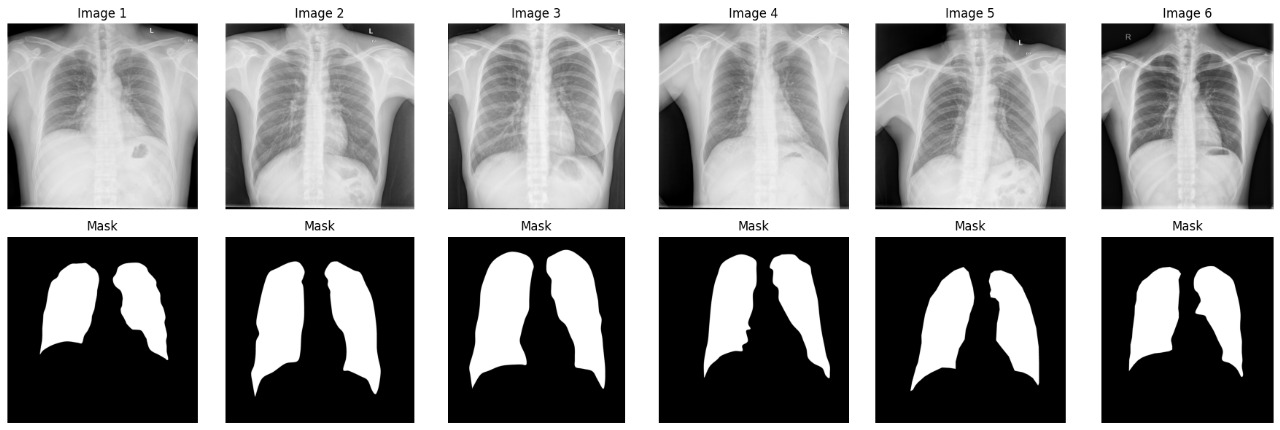


## Assignment Tasks

1. Build a file-pairing script to match each image with its mask; print a summary of matched pairs and missing files.  
2. Create train/val/test splits (80/10/10) with a fixed random seed.  
3. Implement preprocessing and mask-safe augmentations (flips, crop/zoom; nearest-neighbor resize for masks).  
4. Implement the classical U-Net structure that you have learned about in the lectures.  
5. Implement a U-Net with Transfer Learning (e.g., ResNet50, VGG16, MobileNetV2).  
6. Train your models with a composite loss (e.g., 0.5·BCE + 0.5·DiceLoss), track Dice and IoU metrics, and use callbacks (ModelCheckpoint, EarlyStopping).  
7. Evaluate on the test set; report metrics and show qualitative results.  


## Task 0.1 : Data Organization & Pairing
- Build a file-pairing script to match each image with its mask.  
- Print a summary of matched pairs and missing files.
- Show the distribution of training, validation and test set
##  Set DATA_ROOT to the path of the Images folder located in your CA3 assignment folder.

Total images: 200
Matched pairs: 200
Missing masks: 0


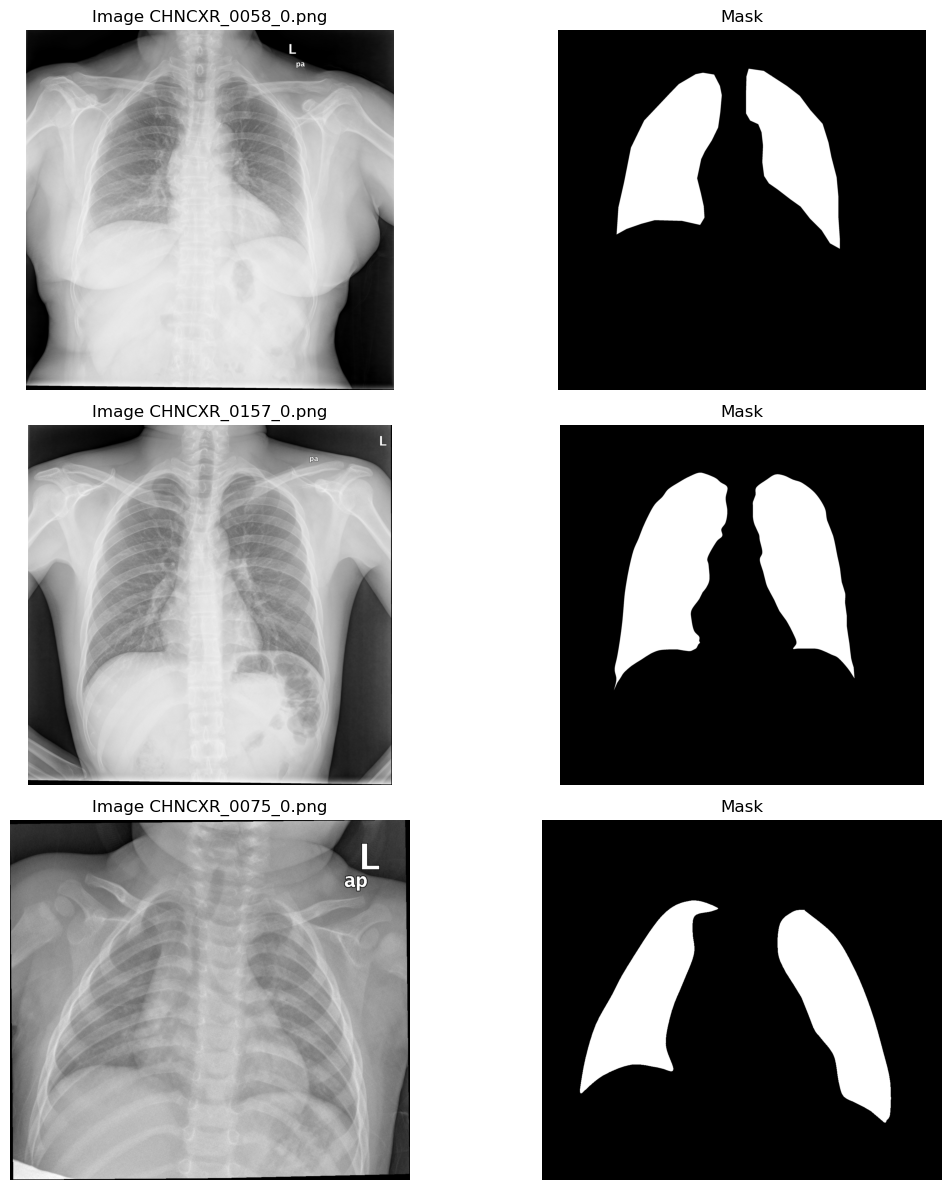

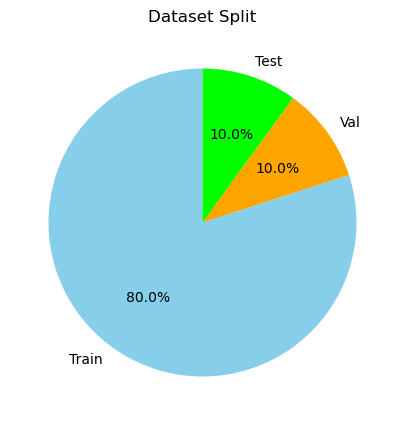

In [1]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib
import tensorflow as tf

import importlib
import utilities as ut
importlib.reload(ut)

DATA_ROOT = r"C:\Users\alfa\OneDrive - Norwegian University of Life Sciences\Desktop\AML_NMBU\DAT300\DAT300_2025\Assignments\CA3\Images"
IMG_DIR = os.path.join(DATA_ROOT, "CXR_png")
MSK_DIR = os.path.join(DATA_ROOT, "masks")

pairs, missing = ut.build_pairs(IMG_DIR, MSK_DIR)
ut.report_pairs(pairs, missing)
ut.peek_pairs(pairs, n_show=3)

train, val, test = ut.split_dataset(pairs, seed=42)
ut.plot_split_distribution(train, val, test)


## Task 0.1 : Preprocessing & Augmentation
- Implement preprocessing for images and masks.  
- Ensure masks are not corrupted during transformations.


### Image
- Decode as RGB (3 channels), resize to `IMG_SIZE`.
- Use ResNet preprocess.

### Mask
- Decode as 1 channel, nearest resize (to preserve labels).
- Binarize.

### Augmentations (mask-safe)
- Horizontal flip
- Light zoom/shift via pad + random crop
- Light brightness/contrast jitter (image only)




In [5]:
import importlib
import utilities as ut
importlib.reload(ut)

# Build datasets
train_ds = ut.make_dataset(train, augment_data=False)   # no augmentation
val_ds   = ut.make_dataset(val, augment_data=False)
train_aug_ds = ut.make_dataset(train, augment_data=True)

# -------------------------
# Check dataset sizes
# -------------------------
print("Pairs available:")
print("  Train set:", len(train), "pairs")
print("  Val set  :", len(val), "pairs")
print("  Test set :", len(test), "pairs")

# Count actual batches and images
def count_batches_and_images(ds, name):
    n_batches = 0
    n_images = 0
    for imgs, msks in ds:
        n_batches += 1
        n_images += imgs.shape[0]
    print(f"{name}: {n_batches} batches, {n_images} images")

count_batches_and_images(train_ds, "Train dataset (no aug)")
count_batches_and_images(val_ds, "Validation dataset")
count_batches_and_images(train_aug_ds, "Train dataset (with aug)")

# -------------------------
# Inspect shapes before augmentation
# -------------------------
for imgs, msks in train_ds.take(1):
    print("Before augmentation - images:", imgs.shape, "masks:", msks.shape)

# Inspect shapes after augmentation
for imgs, msks in train_aug_ds.take(1):
    print("After augmentation - images:", imgs.shape, "masks:", msks.shape)


Pairs available:
  Train set: 160 pairs
  Val set  : 20 pairs
  Test set : 20 pairs
Train dataset (no aug): 40 batches, 160 images
Validation dataset: 5 batches, 20 images
Train dataset (with aug): 40 batches, 160 images
Before augmentation - images: (4, 512, 512, 3) masks: (4, 512, 512, 1)
After augmentation - images: (4, 512, 512, 3) masks: (4, 512, 512, 1)


## Part 1 - Model Implementation 

## Intersection over Union

The IoU score is a popular metric in both segmentation and object detection problems.

If you want to use the `plot_training_history` function in the `utilities.py` library remember to compile the model with the TP, TN, FP, FN metrics such that you can estimate the *Intersection-over-Union*.  
However, it is voluntary to estimate IoU.(check the `utilities.py`)

See example below:


In [ ]:
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from utilities import f1_score, plot_training_history

# Example model compile
model.compile(
    optimizer="Something",
    loss="Something else",
    metrics=[
        FalseNegatives(),
        FalsePositives(),
        TrueNegatives(),
        TruePositives(),
        f1_score,
        # Other metrics of your choice
    ]
)

training_history = model.fit(X_train, y_train, ...)
plot_training_history(training_history)


You have also been provided with a custom F1-score metric in the `utilities.py` library, which is specific for image segmentation.  
**This is mandatory to use when compiling the model.**


## Task 1.1: Model Implementation 
Implement the classical U-net structure that you have learned about in the lectures.  
Feel free to experiment with the number of layers, loss-function, batch-normalization, etc.  

**Remember to compile with the F1-score metric.**


## Task 1.2: Train the model, and plot the training history
Feel free to use the `plot_training_history` function from the provided library `utilities.py`.


## Task 1.3: Visualize model predictions
Make a plot that illustrates the original image, the predicted mask, and the ground truth mask. You can use visualize_predictions() in `utilities.py` 

## Task 2: Implementing U-Net with Transfer Learning

Implement a model with the U-net structure that you have learned about in the lectures, but now with a pre-trained backbone. 
There are many pre-trained back-bones to choose from. Pick freely from the selection here tf.keras.applications, or here Keras model scores (nicer table in the second link). 
Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. Many of the backbones available are quite big, so you might find it quite time-consuming to train them on your personal computers.

For those with a dedicated graphics card (NVIDIA and AMD) Tensorflow or PyTorch (not syllabus)

And wants to experiment with their own compute resources (can be a lot of fun)

Tensorflow: https://learn.microsoft.com/en-us/windows/ai/directml/gpu-tensorflow-plugin

PyTorch: https://learn.microsoft.com/en-us/windows/ai/directml/pytorch-windows



## Task 2.1: Transfer Learning Model Implementation

In this task, we will implement a U-Net model that uses the pre-trained weights of popular public networks (e.g., **VGG16** and **ResNet50**) as encoders. This is a common transfer learning strategy for segmentation.

### Example 1: U-Net with VGG16 backbone

from tensorflow.keras.applications import VGG16

from tensorflow.keras.applications import ResNet50

##  Task 2.2: Train the transfer learning model and plot the training history

Feel free to use the plot_training_history function from the provided library utilities.py


# Part 2 - Discussion

#### Question 1: Which model architectures did you explore, and what type of hyperparameter optimization did you try?
Answer 1:  

---

#### Question 2: Which of the models did you choose to train as your final submission, and how long did it take to train?
Answer 2:  

---

#### Question 3: What were the biggest challenges with this assignment?
Answer 3:  
